# FE (Gram) algorithm

In [64]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy

### Step 1: Obtain orthonormal bases of Gram polynomials on the boundaries

### Euclidean Vectors

In [38]:
basis = [np.array([3, 1, 3]), np.array([2, 2, 2]), np.array([1, 8, 6])]

#Write basis vector as columns of matrix V
m = 3
V = np.zeros((m, m))
V[:, 0] = basis[0]
V[:, 1] = basis[1]
V[:, 2] = basis[2]

def sp(u, v):
    return np.sum(u * v)

def proj(u, v):
    a1 = sp(v, u) 
    a2 = sp(u, u)
    return a1/a2 * u 

def norm(u):
    return np.sqrt(sp(u, u))

#### Classical Gram-Schmidt orthogonalisation

In [40]:
def classicalGramSchmidt(V): 
    n, k = V.shape
    U = np.zeros(V.shape) 
    U[:, 0] = V[:, 0] / norm(V[:, 0]) 
    print(U)

    for i in range(1, k): 
        U[:, i] = V[:, i]
        for j in range(i): 
            U[:, i] = U[:, i] - proj(U[:, j], U[:, i])
        U[:, i] = U[:, i] / norm(U[:, i])
    return U

U = classicalGramSchmidt(V)
u1 = U[:, 0]
u2 = U[:, 1]
u3 = U[:, 2]
u1, u2, u3, sp(u1, u2), sp(u1, u1), sp(u2, u2), sp(u1, u3)

[[0.6882472  0.         0.        ]
 [0.22941573 0.         0.        ]
 [0.6882472  0.         0.        ]]


(array([0.6882472 , 0.22941573, 0.6882472 ]),
 array([-0.16222142,  0.97332853, -0.16222142]),
 array([-0.70710678,  0.        ,  0.70710678]),
 -1.942890293094024e-16,
 0.9999999999999996,
 1.0,
 3.3306690738754696e-16)

#### Modified Gram-Schmidt orthogonalisation

In [42]:
def modifiedGramSchmidt(V): 
    n, k = V.shape
    U    = np.copy(V) 
    U[:, 0] = V[:, 0] / norm(V[:, 0]) 

    for i in range(1, k): 
        for j in range(i, k): 
            U[:, j] = U[:, j] - proj(U[:, i - 1], U[:, j])

        U[:, i] = U[:, i] / norm(U[:, i])
    return U

U = modifiedGramSchmidt(V)
u1 = U[:, 0]
u2 = U[:, 1]
u3 = U[:, 2]
u1, u2, u3, sp(u1, u2), sp(u1, u1), sp(u2, u2), sp(u1, u3)

(array([0.6882472 , 0.22941573, 0.6882472 ]),
 array([-0.16222142,  0.97332853, -0.16222142]),
 array([-0.70710678,  0.        ,  0.70710678]),
 -1.942890293094024e-16,
 0.9999999999999996,
 1.0,
 3.3306690738754696e-16)

### Polynomial bases

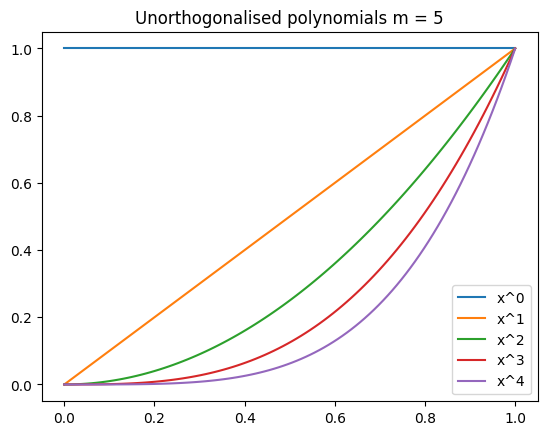

i = 0 u_ij = [ 1.00000000e+00  1.14491749e-16 -1.83880688e-16  4.40619763e-16
  8.25381430e-15]
i = 1 u_ij = [1.14491749e-16 1.00000000e+00 2.49800181e-16 5.55111512e-17
 1.24553146e-14]
i = 2 u_ij = [-1.83880688e-16  2.49800181e-16  1.00000000e+00 -3.67761377e-16
  7.52869989e-15]
i = 3 u_ij = [ 4.40619763e-16  5.55111512e-17 -3.67761377e-16  1.00000000e+00
  1.30451205e-15]
i = 4 u_ij = [8.25381430e-15 1.24553146e-14 7.52869989e-15 1.30451205e-15
 1.00000000e+00]


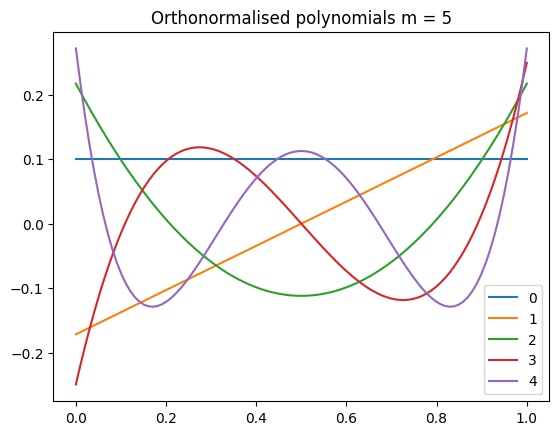

In [70]:
x = np.linspace(0, 1, 100) 

#Linear map for polynomial scalar product
A = np.zeros((m, len(x)))
for i in range(m): 
    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
    A[i] = x**i

#Write basis vector as columns of matrix V
V = np.identity(m) 

plt.title(f"Unorthogonalised polynomials m = {m}")
for i in range(m):
    plt.plot(x, V[:, i] @ A, label=f"x^{i}")
plt.legend()
plt.show()

def sp(u, v):
    return np.sum((u @ A) * (v @ A))

def proj(u, v):
    a1 = sp(v, u) 
    a2 = sp(u, u)
    return a1/a2 * u 

def norm(u):
    return np.sqrt(sp(u, u))

def modifiedGramSchmidt(V): 
    n, k = V.shape
    U    = np.copy(V) 
    U[:, 0] = V[:, 0] / norm(V[:, 0]) 

    for i in range(1, k): 
        for j in range(i, k): 
            U[:, j] = U[:, j] - proj(U[:, i - 1], U[:, j])

        #Apply Gram-Schmidt twice to reduce round-off errors
        for j in range(i, k): 
            U[:, j] = U[:, j] - proj(U[:, i - 1], U[:, j])

        U[:, i] = U[:, i] / norm(U[:, i])
    return U

U = modifiedGramSchmidt(V)
for i in range(m):
    u_ij = np.zeros(m) 
    for j in range(m):
        u_ij[j] = sp(U[:, i], U[:, j])
    print(f"i = {i} u_ij = {u_ij}")

plt.title(f"Orthonormalised polynomials m = {m}")
for i in range(m):
    plt.plot(x, U[:, i] @ A, label=f"{i}")
plt.legend()
plt.show()

#### The all-in-one solution

In [78]:
class GramSchmidt:
    def __init__(self, x, m):
        self.m = m 
        self.A = np.zeros((m, len(x)))
        for i in range(m): 
            #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
            self.A[i] = x**i

        #Write basis vector as columns of matrix V
        self.V = np.identity(m) 

        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        A = np.zeros((self.m, len(x)))
        for i in range(m): 
            #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
            self.A[i] = x**i
        return U[:, basis_element] @ A 
    
    def sp(self, u, v):
        return np.sum((u @ self.A) * (v @ self.A))

    def proj(self, u, v):
        a1 = sp(v, u) 
        a2 = sp(u, u)
        return a1/a2 * u 

    def norm(self, u):
        return np.sqrt(sp(u, u))

    def modifiedGramSchmidt(self, V): 
        n, k = V.shape
        U    = np.copy(V) 
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])

            #Apply Gram-Schmidt twice to reduce round-off errors
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])

            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        coeffs = np.zeros(self.m) 

        for i in range(self.m): 
            coeffs[i] = np.sum(f * (self.U[:, i] @ self.A))

        return coeffs
    
    def reconstructFunction(self, coeffs): 
        frec = np.zeros(A.shape[1])
        for i in range(self.m): 
            frec += coeffs[i] * (self.U[:, i] @ self.A)
        return frec 

### Step 2: Function approximation via projection

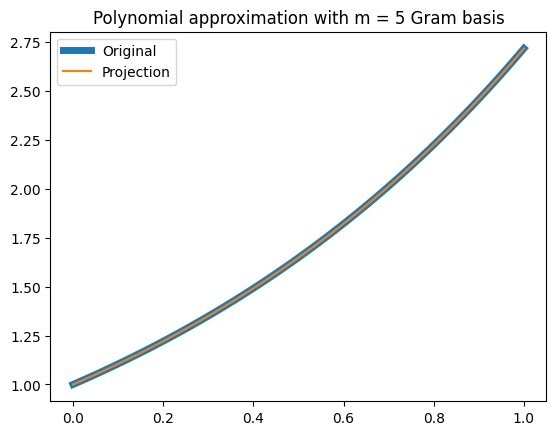

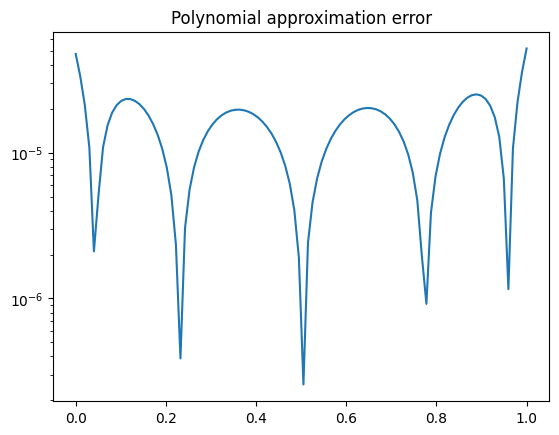

In [79]:
x = np.linspace(0, 1, 100) 
f = np.exp(x)

gs = GramSchmidt(x, m=5)

coeffs = gs.projectFunction(f) 
frec   = gs.reconstructFunction(coeffs) 

plt.title(f"Polynomial approximation with m = {m} Gram basis")
plt.plot(x, f,    lw = 5,  label="Original")
plt.plot(x, frec,          label="Projection")
plt.legend()
plt.show()
plt.title(f"Polynomial approximation error")
plt.plot(x, np.abs(f - frec))
plt.yscale("log")
plt.show()

### Step 3: Compute FC(SVD) continuations for even and odd pairs of Gram polynomials

In [65]:
class FourierExtension:
    def __init__(self, N, Ncoll, theta, chi, cutoff):
        self.N, self.Ncoll, self.theta, self.chi, self.cutoff = N, Ncoll, theta, chi, cutoff 
        self.Meven = self.getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
        self.Modd  = self.getFPICSUOddMatrix (N, Ncoll, theta, chi) 

        self.dx    = chi / (Ncoll - 1) 
        self.x     = np.arange(-Ncoll + 1, Ncoll) * self.dx

        self.Meveninv  = self.invertRealM(self.Meven, cutoff)
        self.Moddinv   = self.invertRealM(self.Modd,  cutoff)

    def getX(self): 
        return self.x, self.dx
    
    def getFPICSUEvenMatrix(self, N, Ncoll, theta, chi): 
        M  = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.cos(j * np.pi / theta * i * dx)
        return M

    def getFPICSUOddMatrix(self, N, Ncoll, theta, chi): 
        M = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.sin(j * np.pi / theta * i * dx)
        return M

    def invertRealM(self, M, cutoff):
        U, s, Vh = scipy.linalg.svd(M)
        sinv = np.zeros(M.T.shape)
        for i in range(np.min(M.shape)):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]
        return Vh.T @ sinv @ U.T


    def reconstructOdd(self, x, a, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, coeff in enumerate(a): 
            rec += coeff * np.sin(np.pi / theta * j * x)
        return rec

    def reconstructEven(self, x, a, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, coeff in enumerate(a): 
            rec += coeff * np.cos(np.pi / theta * j * x)
        return rec
    
    def reconstruct(self, x, aodd, aeven, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)): 
            rec += ( evecoeff / ( 2 * 1 ) + oddcoeff / ( 2 * 1j ) ) * ( np.exp(+ 1j * np.pi / theta * j * x) )
        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)): 
            rec += ( evecoeff / ( 2 * 1 ) - oddcoeff / ( 2 * 1j ) ) * ( np.exp(- 1j * np.pi / theta * j * x) )
        return rec
    
    
    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 5): 
        a       = Minv @ f
        r       = M @ a - f
        counter = 0
        while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
            delta    = Minv @ r
            a        = a - delta 
            r        = M @ a - f
            counter += 1
        return a

    def computeExtension(self, f, xext, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        frec     = self.reconstruct(xext, aodd, aeven, self.theta)
        return frec
    
    def computeEvenExtension(self, f, xext, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        frec     = self.reconstruct(xext, aodd, aeven, self.theta)
        return frec
    

    def computeExtension(self, f, xext, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        frec     = self.reconstruct(xext, aodd, aeven, self.theta)
        return frec
    
    def rescaleToPhysical(self, x): 
        a = x[0]
        b = x[-1]
        sx = ( x - a ) / ( b - a ) 
        sx = sx * (2*self.chi) - self.chi
        return sx 

    def rescaleToExtended(self, x): 
        a = x[0]
        b = x[-1]
        sx = ( x - a ) / ( b - a ) 
        sx = sx * (2*self.theta) - self.theta
        return sx
    
    def plotApproximationErorr(self, xext, forg, frec):
        plt.title("Approximation error of f")
        plt.yscale("log")
        plt.plot(xext, np.abs(forg - frec))
        plt.show() 


In [ ]:

m = 5
n = 10 
nDelta = 10 
nd = 27
x = np.linspace(0, 1, nd)
x[1] - x[0], 1/(nd - 1)

leftBoundary  = x[       :nDelta]
rightBoundary = x[-nDelta:      ]

Gamma = 150 
xl = np.linspace(rightBoundary[0], )

#Linear map for polynomial scalar product
A = np.zeros((m, Gamma))
for i in range(m): 
    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
    A[i] = leftBoundary**i

plt.title(f"Orthonormalised polynomials m = {m}")
for i in range(m):
    plt.plot(leftBoundary, U[:, i] @ A, label=f"{i}")
plt.legend()
plt.show()
